# Image Classification

## Loading and Preprocessing

In [1]:
#Import packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import scipy as sp
from scipy.ndimage import interpolation
import cv2
import keras
from keras.utils import np_utils
import time
from keras.models import model_from_json
import os
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization


C:\Users\navin\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#Padding Functions

def pad_with(vector, pad_width, iaxis, kwargs):
    pad_value = kwargs.get('padder', 0)
    vector[:pad_width[0]] = pad_value
    vector[-pad_width[1]:] = pad_value
    return vector

def pid(a):
    a=a.reshape(28,28)
    b = np.pad(a, 2, pad_with)
    return(b.flatten())

In [3]:
#Import Data and padding
#Padding is done to preserve as much information after convolution

data = pd.read_csv('Train.csv')
x_train = data.drop('label',axis = 1)
labels = np.array(data['label'])
train = np.zeros((60000,1024))
for i in range(len(train)):
    train[i] = pid(x_train.iloc[i])
print('Train shape: ',train.shape)
print('Label shape: ',labels.shape)

tdata = pd.read_csv('Test.csv')
x_test = tdata.drop('label',axis = 1)
tlabels = np.array(tdata['label'])
test = np.zeros((10000,1024))
for i in range(len(test)):
    test[i] = pid(x_test.iloc[i])
print('Test shape: ',test.shape)
print('Label shape: ',tlabels.shape)

C:\Users\navin\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\ipykernel\__main__.py:10: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


Train shape:  (60000, 1024)
Label shape:  (60000,)
Test shape:  (10000, 1024)
Label shape:  (10000,)


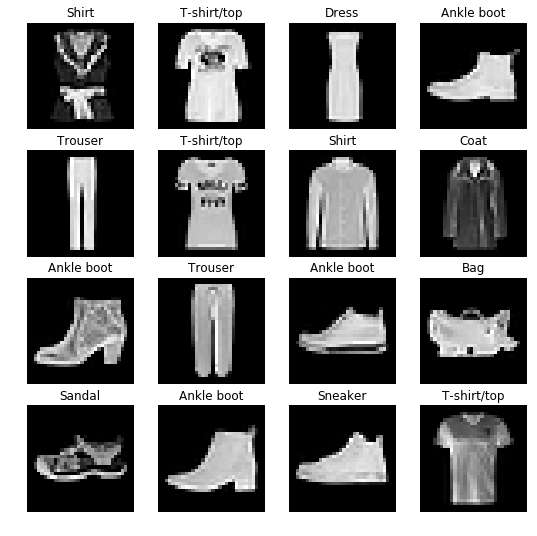

In [4]:
# Dataset Visualizations:

objects = {0: 'T-shirt/top',
           1: 'Trouser',
           2: 'Pullover',
           3: 'Dress',
           4: 'Coat',
           5: 'Sandal',
           6: 'Shirt',
           7: 'Sneaker',
           8: 'Bag',
           9: 'Ankle boot'}

i, j = plt.subplots(4, 4, figsize=(9,9))
for n in j:
    for axe in n:
        index = np.random.randint(60000)
        img = train[index]
        obj = labels[index]
        axe.imshow(img.reshape(32,32), cmap='gray')
        axe.set_title(objects[obj])
        axe.set_axis_off()
        
plt.show()



In [5]:
# Preprocessing Functions

def display(image):
    plt.imshow(image.reshape(32,32), cmap = 'gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()
    

#The next two functions are for centering the image and then deskewing if needed

def moments(image):
    c0,c1 = np.mgrid[:image.shape[0],:image.shape[1]] 
    totalImage = np.sum(image) #sum of pixels
    m0 = np.sum(c0*image)/totalImage #mu_x
    m1 = np.sum(c1*image)/totalImage #mu_y
    m00 = np.sum((c0-m0)**2*image)/totalImage #var(x)
    m11 = np.sum((c1-m1)**2*image)/totalImage #var(y)
    m01 = np.sum((c0-m0)*(c1-m1)*image)/totalImage #covariance(x,y)
    mu_vector = np.array([m0,m1]) 
    covariance_matrix = np.array([[m00,m01],[m01,m11]]) 
    return mu_vector, covariance_matrix

def deskew(image):
    image = image.reshape(32,32)
    c,v = moments(image)
    alpha = v[0,1]/v[0,0]
    affine = np.array([[1,0],[alpha,1]])
    ocenter = np.array(image.shape)/2.0
    offset = c-np.dot(affine,ocenter)
    result = interpolation.affine_transform(image,affine,offset=offset)
    return result.flatten()


#This function removes noise
def denoise(image):
    image = image.reshape(32,32)
    image = np.uint8(image)    
    dst = cv2.fastNlMeansDenoising(image,None,10,7,21)
    return dst.flatten()


#Removing any graining
def blur(image):
    image = image.reshape(32,32)
    image = np.uint8(image)
    blur = cv2.GaussianBlur(image,(5,5),0)
    return blur.flatten()
    

def preprocess_train(image):
    x = denoise(image)
    y = blur(x)
    z = deskew(y)
    return z
    

In [8]:
df = train.copy()
for i in range(len(df)):
    df[i] = preprocess_train(df[i])

# Convolution Neural Network

In [5]:
#Transform data for neural nets
#Pixels are first scaled so that all values lie within 0 and 1
#The input is then transormed and reshaped to be appropriate for the neural network input


X_train = df.copy()
X_train = X_train.astype('float32')
X_train /= 255
X_train = np.array(X_train)
X_train = X_train.reshape([-1,32,32,1])
y_train = np_utils.to_categorical(labels, 10)

X_test = test.copy()
X_test = X_test.astype('float32')
X_test /= 255
X_test = np.array(X_test)
X_test = X_test.reshape([-1,32,32,1])
y_test = np_utils.to_categorical(tlabels, 10)

print('y_train shape: ',y_train.shape)
print('y_test shape: ',y_test.shape)


y_train shape:  (60000, 10)
y_test shape:  (10000, 10)


In [9]:
#Architecture

from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential()

model.add(Convolution2D(32, (5, 5), input_shape=[32,32,1], activation='relu'))
model.add(BatchNormalization())

model.add(Convolution2D(32, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())

model.add(Convolution2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Convolution2D(64, (2, 2), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.15))

model.add(Convolution2D(64, (2, 2), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Flatten())
model.add(BatchNormalization())

model.add(Dense(units=128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(units=128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(units=10, activation='softmax'))

In [12]:
#Summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 32)        128       
__________

In [13]:
#Data Augmentation
#Augmentation is done inorder to increase the number of training samples and also to control overfitting

from keras.preprocessing.image import ImageDataGenerator

image_aug = ImageDataGenerator(rotation_range=7,
                                   zoom_range=0.07,
                                   shear_range=0.08,
                                   width_shift_range=0.07,
                                   horizontal_flip=True)

image_aug.fit(X_train)


In [14]:
#Model Fitting

from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

#The Adam optimizer is used

opt = Adam(lr=0.01, beta_1=0.9, beta_2=0.9, decay=0., amsgrad=True)

# Learning Rate reducer is set to reduce if the validation accuracy does not improve for 3 consecutive epochs

reducer = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.8, min_lr=0.0001)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


cnn_model = model.fit_generator(image_aug.flow(X_train, y_train, batch_size=64),
                 steps_per_epoch=X_train.shape[0] / 64,
                 epochs=50,
                 validation_data=(X_test, y_test),
                 callbacks=[reducer],
                 verbose=2)

model_605 = model.to_json()
with open("final.json", "w") as json_file:
    json_file.write(model_605)
model.save_weights("final.h5")
print("Saved model to disk")


Epoch 1/50
 - 725s - loss: 0.5699 - acc: 0.7912 - val_loss: 0.3471 - val_acc: 0.8705
Epoch 2/50
 - 690s - loss: 0.4017 - acc: 0.8552 - val_loss: 0.2878 - val_acc: 0.8959
Epoch 3/50
 - 689s - loss: 0.3561 - acc: 0.8706 - val_loss: 0.2467 - val_acc: 0.9078
Epoch 4/50
 - 694s - loss: 0.3271 - acc: 0.8822 - val_loss: 0.2308 - val_acc: 0.9142
Epoch 5/50
 - 686s - loss: 0.3143 - acc: 0.8867 - val_loss: 0.2314 - val_acc: 0.9134
Epoch 6/50
 - 695s - loss: 0.2980 - acc: 0.8928 - val_loss: 0.2187 - val_acc: 0.9173
Epoch 7/50
 - 686s - loss: 0.2882 - acc: 0.8963 - val_loss: 0.2131 - val_acc: 0.9214
Epoch 8/50
 - 686s - loss: 0.2784 - acc: 0.8991 - val_loss: 0.2212 - val_acc: 0.9167
Epoch 9/50
 - 702s - loss: 0.2738 - acc: 0.9017 - val_loss: 0.2012 - val_acc: 0.9280
Epoch 10/50
 - 689s - loss: 0.2641 - acc: 0.9035 - val_loss: 0.1991 - val_acc: 0.9275
Epoch 11/50
 - 693s - loss: 0.2571 - acc: 0.9085 - val_loss: 0.1879 - val_acc: 0.9328
Epoch 12/50
 - 705s - loss: 0.2544 - acc: 0.9089 - val_loss: 0.

In [16]:
#train score
score = model.evaluate(X_train,y_train,verbose=1)
print(score)

60000/60000 [==============================] - 245s 4ms/step

In [17]:
#test score
score = model.evaluate(X_test,y_test,verbose=1)
print(score)

10000/10000 [==============================] - 40s 4ms/step

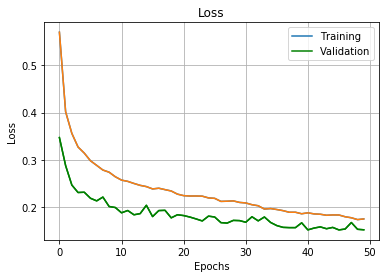

In [16]:
#Loss function is plotted over all epochs

loss = cnn_model.history['loss']
val_loss = cnn_model.history['val_loss']
acc = cnn_model.history['acc']
val_acc = cnn_model.history['val_acc']

# loss plot
plt.plot(loss)
plt.plot(val_loss, 'g')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend(["Training", "Validation"])
plt.grid()
plt.show()


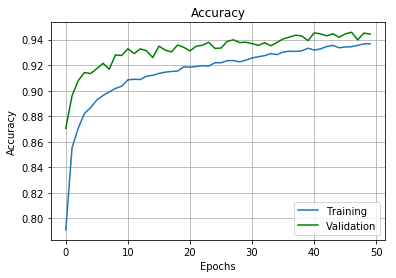

In [17]:
#Accurcy is plotted over all epochs

plt.plot(acc)
plt.plot(val_acc, 'g')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend(['Training', 'Validation'], loc=4)
plt.grid()
plt.show()

In [9]:
#Confusion Matrix Function

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()



Normalized confusion matrix
[[0.846 0.001 0.012 0.016 0.    0.    0.124 0.    0.001 0.   ]
 [0.    0.999 0.    0.001 0.    0.    0.    0.    0.    0.   ]
 [0.014 0.    0.885 0.015 0.043 0.    0.043 0.    0.    0.   ]
 [0.003 0.007 0.001 0.97  0.007 0.    0.012 0.    0.    0.   ]
 [0.    0.001 0.007 0.021 0.94  0.    0.03  0.    0.001 0.   ]
 [0.    0.    0.    0.    0.    0.989 0.    0.009 0.    0.002]
 [0.045 0.002 0.022 0.028 0.036 0.    0.865 0.    0.002 0.   ]
 [0.    0.    0.    0.    0.    0.003 0.    0.976 0.    0.021]
 [0.001 0.    0.001 0.001 0.    0.001 0.001 0.    0.995 0.   ]
 [0.    0.    0.    0.    0.    0.003 0.    0.02  0.    0.977]]


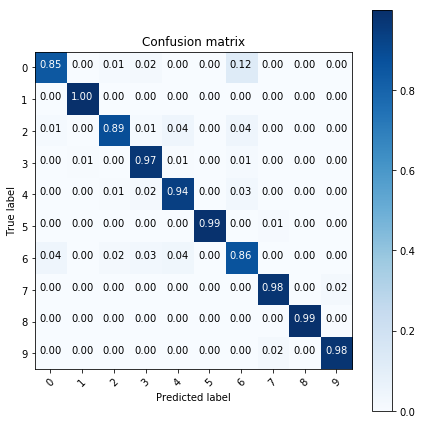

In [11]:
#Confusion Matrix

y_pred = cnn_model.predict(X_test)
pred = np.zeros(10000)
for i in range(len(y_pred)):
    pred[i] = np.argmax(y_pred[i])

cm =confusion_matrix(tlabels,pred)
plot_confusion_matrix(cm,[0,1,2,3,4,5,6,7,8,9],normalize=True)
    

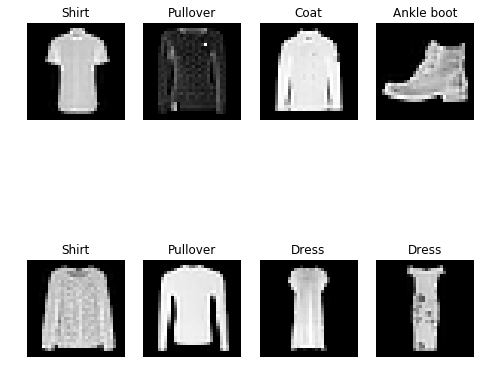

In [13]:
# Visualization of Predictions:


objects = {0: 'T-shirt/top',
           1: 'Trouser',
           2: 'Pullover',
           3: 'Dress',
           4: 'Coat',
           5: 'Sandal',
           6: 'Shirt',
           7: 'Sneaker',
           8: 'Bag',
           9: 'Ankle boot'}

f, axes = plt.subplots(2, 4, figsize=(8,8))
for row in axes:
    for axe in row:
        index = np.random.randint(10000)
        img = test[index]
        obj = pred[index]
        axe.imshow(img.reshape(32,32), cmap='gray')
        axe.set_title(objects[obj])
        axe.set_axis_off()
        
plt.show()



## Random Forest 

In [27]:
#Random Forest

X_train = df.copy()
X_train = X_train.astype('float32')
X_train /= 255
X_train = np.array(X_train)
y_train = labels

X_test = test.copy()
X_test = X_test.astype('float32')
X_test /= 255
X_test = np.array(X_test)
y_test = tlabels

In [30]:
#Gridsearch and cross validation is used to hypertune the parameters

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

max_depth=[4,8,16,32,64]
ntrees = [8,16,32,64,128]
parameters = {'max_depth':max_depth, 'n_estimators':ntrees}

model =  RandomForestClassifier(max_features='sqrt')
clf = GridSearchCV(model, parameters,return_train_score=True,cv=5)
clf.fit(X_train, y_train)
test_acc = clf.score(X_test,y_test)
train_acc = clf.score(X_train,y_train)
print('Best parameters:{}'.format(clf.best_params_))
print('Train Accuracy: ',train_acc)
print('Test Accuracy: ',test_acc)


Best parameters:{'max_depth': 64, 'n_estimators': 128}
Train Accuracy:  1.0
Test Accuracy:  0.8848


Normalized confusion matrix
[[0.869 0.    0.012 0.026 0.002 0.001 0.079 0.    0.011 0.   ]
 [0.003 0.971 0.005 0.014 0.003 0.001 0.003 0.    0.    0.   ]
 [0.007 0.001 0.815 0.012 0.106 0.    0.049 0.    0.01  0.   ]
 [0.016 0.007 0.005 0.932 0.021 0.    0.019 0.    0.    0.   ]
 [0.001 0.    0.071 0.031 0.852 0.    0.042 0.    0.003 0.   ]
 [0.    0.    0.    0.    0.    0.948 0.    0.038 0.004 0.01 ]
 [0.169 0.001 0.1   0.029 0.076 0.    0.609 0.    0.016 0.   ]
 [0.    0.    0.    0.    0.    0.019 0.    0.926 0.    0.055]
 [0.002 0.001 0.007 0.    0.003 0.001 0.006 0.002 0.977 0.001]
 [0.    0.    0.    0.    0.    0.006 0.001 0.041 0.003 0.949]]


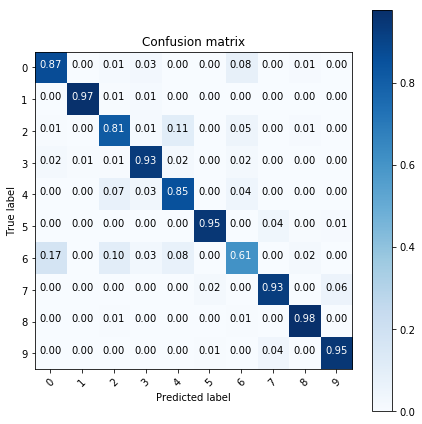

In [31]:
#Confusion Matrix

pred =  clf.predict(X_test)
cm =confusion_matrix(y_test,pred)
plot_confusion_matrix(cm,[0,1,2,3,4,5,6,7,8,9],normalize=True)


In [9]:
#Learning Curve function

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

C:\Users\navin\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\sklearn\model_selection\_validation.py:811: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(train_sizes_abs.dtype, np.float):


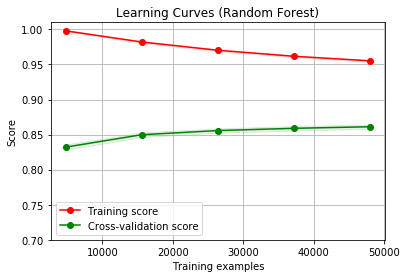

In [25]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


title = "Learning Curves (Random Forest)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = RandomForestClassifier(n_estimators=65, max_depth = 15, max_features = 8)
plot_learning_curve(estimator, title, X_train, y_train, ylim=(0.7, 1.01), cv=cv, n_jobs=4)
plt.show()


From the learning curve, it can be seen that there is a significant gap between the training and valdiation scores. This clearly shows that this estimator suffers from overfitting and is not capable of handling the complexity of the problem, inspite of increasing the number of training samples.

## SVM with PCA

In [13]:
#Principal component analysis is used to reduce dimensions for support vector machines.

from sklearn.decomposition import PCA
from sklearn.svm import SVC

n_components = 1000
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)



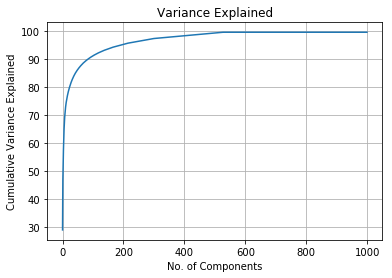

In [14]:
#The amount of variance that each PC explains
var_ratio = pca.explained_variance_ratio_


cum_var=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

plt.plot(cum_var)
plt.xlabel('No. of Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('Variance Explained')
plt.grid()
plt.show()


From the above plot, it is seen that about 90% of the total variance is explained by the first 100 principal components.

In [15]:
n_components = 100
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)

X_train_pca = pca.transform(X_train)

tpca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_test)

X_test_pca = tpca.transform(X_test)

In [23]:
#SVM

sm = SVC(kernel = 'linear',C=10)
sm.fit(X_train_pca,y_train)
ts_score = sm.score(X_test_pca,y_test)
tr_score = sm.score(X_train_pca,y_train)



In [24]:
print('Train Accuracy: ',tr_score)
print('Test Accuracy: ',ts_score)

Train Accuracy:  0.8689333333333333
Test Accuracy:  0.4812


Normalized confusion matrix
[[0.76  0.009 0.027 0.078 0.002 0.002 0.103 0.    0.009 0.01 ]
 [0.024 0.708 0.002 0.192 0.004 0.    0.07  0.    0.    0.   ]
 [0.013 0.006 0.392 0.037 0.197 0.    0.335 0.    0.018 0.002]
 [0.127 0.146 0.038 0.615 0.021 0.001 0.049 0.    0.001 0.002]
 [0.003 0.019 0.175 0.064 0.568 0.    0.167 0.    0.004 0.   ]
 [0.015 0.051 0.027 0.015 0.011 0.593 0.024 0.112 0.11  0.042]
 [0.245 0.005 0.139 0.058 0.284 0.001 0.241 0.    0.024 0.003]
 [0.    0.018 0.018 0.001 0.    0.146 0.006 0.321 0.367 0.123]
 [0.006 0.007 0.289 0.008 0.025 0.14  0.044 0.042 0.282 0.157]
 [0.002 0.    0.001 0.    0.01  0.42  0.003 0.109 0.123 0.332]]


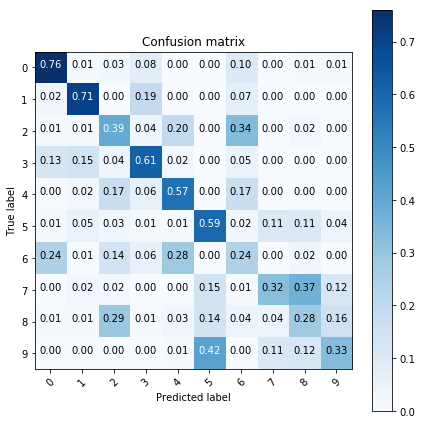

In [33]:
#Confusion Matrix
pred =  sm.predict(X_test_pca)
cm =confusion_matrix(y_test,pred)
plot_confusion_matrix(cm,[0,1,2,3,4,5,6,7,8,9],normalize=True)

# Conclusion

By setting the results of the random forest and SVM as benchmarks, and comparing them with that of the convolution network, the superiority of the deep learning methods can be clearly seen. The performance of the neural network was arounnd 15% better than random forest and over 95% better than SVM. A large part of this can attributed to the hierarchial way in which the learning process takes place in these networks by constantly updating weights and by back propagation. Though SVM’s and random forests may work well for smaller datsets with little ouliers, neural networks have the edge for larger datasets and complex problems like image classification